Inspired/based on https://github.com/rayidghani/magicloops

In [2]:
import pipeline_v2 as pipeline
import importlib
import datetime
import pandas as pd
import numpy as np

# Read data

In [3]:
importlib.reload(pipeline)

data = pipeline.read_csv('projects_2012_2013.csv')

Reading file...
Done


# Explore data

Data exploration...

Number of rows: 124976

Columns and types of data:
projectid                                  object
teacher_acctid                             object
schoolid                                   object
school_ncesid                             float64
school_latitude                           float64
school_longitude                          float64
school_city                                object
school_state                               object
school_metro                               object
school_district                            object
school_county                              object
school_charter                             object
school_magnet                              object
teacher_prefix                             object
primary_focus_subject                      object
primary_focus_area                         object
secondary_focus_subject                    object
secondary_focus_area                       object
resource_type               

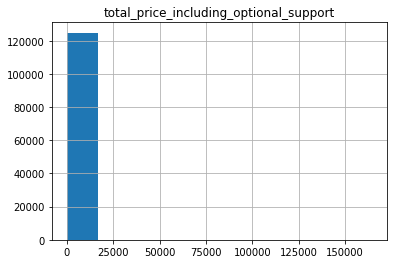

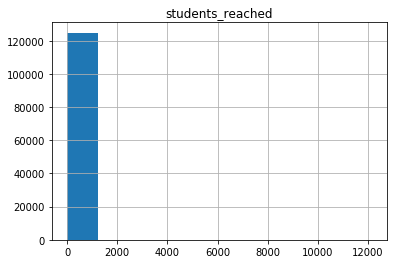

In [4]:
importlib.reload(pipeline)

stats_for_variables = [
  'total_price_including_optional_support',
  'students_reached'
]

variables_for_correlation = [
  'total_price_including_optional_support',
  'students_reached'
]

pipeline.explore_data(data, stats_for_variables, variables_for_correlation)



We can clearly see in the histograms that DebtRadio MontlyIncome have very big outliers.

# Process data

In [5]:
importlib.reload(pipeline)

columns_to_process = [
  'total_price_including_optional_support',
  'students_reached'
]

data = pipeline.pre_process_data(data, columns_to_process)

Pre processing data...
Done


False

# Create discrete features and select predictors

In [6]:
importlib.reload(pipeline)

cols_to_transform = [
'school_state',
'school_metro',
'school_charter',
'school_magnet',
'primary_focus_subject',
'primary_focus_area',
'resource_type',
'poverty_level',
'grade_level',
'eligible_double_your_impact_match']


data = pipeline.create_dummies(data, cols_to_transform)

In [7]:
selected_features = ['school_state_AK','school_state_AL','school_state_AR','school_state_AZ','school_state_CA','school_state_CO','school_state_CT','school_state_DC','school_state_DE','school_state_FL','school_state_GA','school_state_HI','school_state_IA','school_state_ID','school_state_IL','school_state_IN','school_state_KS','school_state_KY','school_state_LA','school_state_MA','school_state_MD','school_state_ME','school_state_MI','school_state_MN','school_state_MO','school_state_MS','school_state_MT','school_state_NC','school_state_ND','school_state_NE','school_state_NH','school_state_NJ','school_state_NM','school_state_NV','school_state_NY','school_state_OH','school_state_OK','school_state_OR','school_state_PA','school_state_RI','school_state_SC','school_state_SD','school_state_TN','school_state_TX','school_state_UT','school_state_VA','school_state_VT','school_state_WA','school_state_WI','school_state_WV','school_state_WY','school_state_nan','school_metro_rural','school_metro_suburban','school_metro_urban','school_metro_nan','school_charter_f','school_charter_t','school_charter_nan','school_magnet_f','school_magnet_t','school_magnet_nan','primary_focus_subject_Applied Sciences','primary_focus_subject_Character Education','primary_focus_subject_Civics & Government','primary_focus_subject_College & Career Prep','primary_focus_subject_Community Service','primary_focus_subject_ESL','primary_focus_subject_Early Development','primary_focus_subject_Economics','primary_focus_subject_Environmental Science','primary_focus_subject_Extracurricular','primary_focus_subject_Foreign Languages','primary_focus_subject_Gym & Fitness','primary_focus_subject_Health & Life Science','primary_focus_subject_Health & Wellness','primary_focus_subject_History & Geography','primary_focus_subject_Literacy','primary_focus_subject_Literature & Writing','primary_focus_subject_Mathematics','primary_focus_subject_Music','primary_focus_subject_Nutrition','primary_focus_subject_Other','primary_focus_subject_Parent Involvement','primary_focus_subject_Performing Arts','primary_focus_subject_Social Sciences','primary_focus_subject_Special Needs','primary_focus_subject_Sports','primary_focus_subject_Visual Arts','primary_focus_subject_nan','primary_focus_area_Applied Learning','primary_focus_area_Health & Sports','primary_focus_area_History & Civics','primary_focus_area_Literacy & Language','primary_focus_area_Math & Science','primary_focus_area_Music & The Arts','primary_focus_area_Special Needs','primary_focus_area_nan','resource_type_Books','resource_type_Other','resource_type_Supplies','resource_type_Technology','resource_type_Trips','resource_type_Visitors','resource_type_nan','poverty_level_high poverty','poverty_level_highest poverty','poverty_level_low poverty','poverty_level_moderate poverty','poverty_level_nan','grade_level_Grades 3-5','grade_level_Grades 6-8','grade_level_Grades 9-12','grade_level_Grades PreK-2','grade_level_nan','eligible_double_your_impact_match_f','eligible_double_your_impact_match_t','eligible_double_your_impact_match_nan']

# Create binary variable

In [8]:
importlib.reload(pipeline)

# The task is to predict if a project on donorschoose will not get fully funded within 60 days of posting.

# Change dates to date format
data['datefullyfunded_formated'] = pd.to_datetime(data['datefullyfunded'])
data['date_posted_formated'] = pd.to_datetime(data['date_posted'])

In [9]:
importlib.reload(pipeline)

from dateutil.relativedelta import relativedelta

#Calculate difference between two dates
data['time_to_fund'] = data['datefullyfunded_formated'].sub(data['date_posted_formated'], axis=0)


In [10]:
importlib.reload(pipeline)

data['time_to_fund'] = pd.to_numeric(data['time_to_fund'] / np.timedelta64(1, 'D'))
data['funded_in_60'] = np.where(data['time_to_fund']<61, 1, 0)

outcome ='funded_in_60'


# Create train and test sets

In [32]:
data['date_posted_formated'].describe()

count                  124976
unique                    731
top       2012-09-30 00:00:00
freq                      728
first     2012-01-01 00:00:00
last      2013-12-31 00:00:00
Name: date_posted_formated, dtype: object

In [40]:
importlib.reload(pipeline)

start_time = str(data['date_posted_formated'].describe()['first']).split(" ")[0]
end_time = str(data['date_posted_formated'].describe()['last']).split(" ")[0]
prediction_window = 6
date_column='date_posted_formated'


sets = pipeline.create_temp_validation_train_and_testing_sets(data, 
                                                                   selected_features,
                                                                   outcome,
                                                                   start_time,
                                                                   end_time,
                                                                   prediction_window,
                                                                   date_column)
x_train = sets[0]
x_test = sets[1]
y_train = sets[2]
y_test = sets[3]

(80800, 118)
(80800,)
(44176, 118)
(44176,)


# Build Clasifiers and parameters generation

In [50]:
importlib.reload(pipeline)

#We define the specific models we want to run

#Not running BA and KNN because they are taking ages
models_to_run=['LR','DT','LR','AB','RF','SVM']#,'BA','KNN']

#Get all posible models and their different sets of parameters
models, parameters_grid = pipeline.get_models_and_parameters()


# Loop over models

In [51]:
importlib.reload(pipeline)

pipeline.iterate_over_models(models_to_run, models, parameters_grid, x_train, x_test, y_train, y_test)


Running LR...
Running DT...
Running LR...
Running AB...
Running RF...
Running SVM...


/home/felipe/.local/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,model_name,model,parameters,p_at_1,r_at_1,p_at_2,r_at_2,p_at_5,r_at_5,p_at_10,r_at_10,p_at_20,r_at_20,p_at_30,r_at_30,p_at_50,r_at_50,auc-roc
0,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.001, 'penalty': 'l1'}",1.000000,0.013956,0.710079,0.019842,0.867301,0.060601,0.837220,0.117025,0.799095,0.223418,0.781467,0.327722,0.785313,0.548924,0.590088
1,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.001, 'penalty': 'l2'}",0.877551,0.012247,0.883352,0.024684,0.871830,0.060918,0.854426,0.119430,0.828862,0.231741,0.817386,0.342785,0.783412,0.547595,0.617331
2,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.1, 'penalty': 'l1'}",0.825397,0.011519,0.828992,0.023165,0.850091,0.059399,0.843559,0.117911,0.827731,0.231424,0.817235,0.342722,0.787577,0.550506,0.619977
3,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.1, 'penalty': 'l2'}",0.845805,0.011804,0.843715,0.023576,0.852808,0.059589,0.845370,0.118165,0.828976,0.231772,0.817235,0.342722,0.786490,0.549747,0.620281
4,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 1, 'penalty': 'l1'}",0.775510,0.010823,0.796149,0.022247,0.843297,0.058924,0.844691,0.118070,0.828297,0.231582,0.816933,0.342595,0.786626,0.549842,0.619914
5,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 1, 'penalty': 'l2'}",0.777778,0.010854,0.800680,0.022373,0.843750,0.058956,0.844238,0.118006,0.827391,0.231329,0.816707,0.342500,0.786671,0.549873,0.619810
6,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 10, 'penalty': 'l1'}",0.773243,0.010791,0.793884,0.022184,0.844203,0.058987,0.844917,0.118101,0.827278,0.231297,0.816556,0.342437,0.786762,0.549937,0.619782
7,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 10, 'penalty': 'l2'}",0.770975,0.010759,0.793884,0.022184,0.844203,0.058987,0.844917,0.118101,0.827617,0.231392,0.816556,0.342437,0.786762,0.549937,0.619771
8,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",1.000000,0.013956,1.000000,0.027943,1.000000,0.069873,0.744623,0.104082,0.672213,0.187943,0.781467,0.327722,0.868843,0.607310,0.547044
9,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",1.000000,0.013956,1.000000,0.027943,1.000000,0.069873,0.744623,0.104082,0.672213,0.187943,0.781467,0.327722,0.868843,0.607310,0.547044
